In [1]:
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import sys
# setting path 
sys.path.append('../')
from NeuralNetworks.NNs import FCFF_3L
from PointSampling.Cube import data_gen_cube, get_unif_grid
from visualization.plots_cube import plot_2d_proj, plot_level_set_cube 
from visualization.cube_training import plot_2d_proj_w
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD 
from Training.training_finite_sum import train_finite_sum
from error_test.cube_error import error_cube, FD_loss

dim = 2


side_length = 6.

domain = data_gen_cube(side_length, dim)

#Right-hand-side of the PDE
def f(X): return 1

#Boundary condition
def g(X): return 0

delta_list = [.75, .3, .1, .05, .01]
alpha_list = [2., 2., 2., 2., 2.]
rounds = len(delta_list)
training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,
    
    'f': f, 
    'g': g, 
    'c': None,
    
    'beta': 0., ## parameter for the +u_i term 
    
    'lambda': 1. #weight parameter for the boundary loss
}

test_data_int, test_data_bound = get_unif_grid(side_length, dim, 101)

/Users/carlosesteveyague/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100%|██████████| 1000/1000 [00:12<00:00, 77.60it/s]


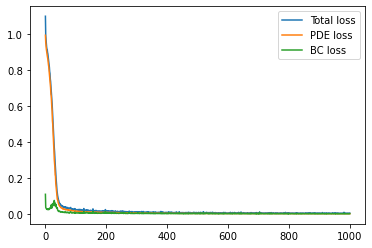

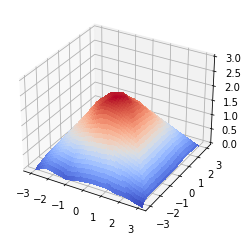

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


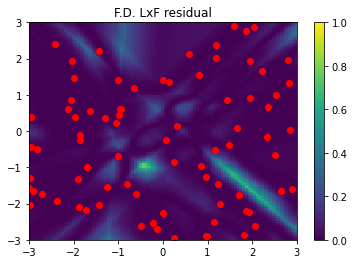

  1%|          | 8/1000 [00:00<00:12, 77.70it/s]

Mean square error: tensor(0.0406)
L-infinity error: tensor(0.9111)


100%|██████████| 1000/1000 [00:14<00:00, 69.05it/s]


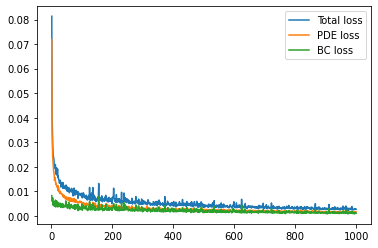

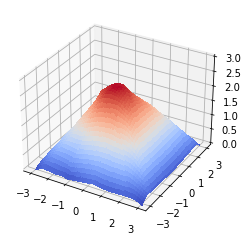

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


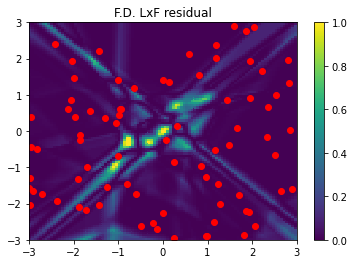

  1%|          | 7/1000 [00:00<00:15, 64.51it/s]

Mean square error: tensor(0.0109)
L-infinity error: tensor(0.5995)


100%|██████████| 1000/1000 [00:13<00:00, 76.43it/s]


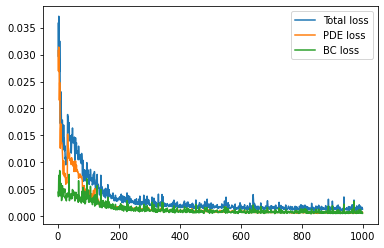

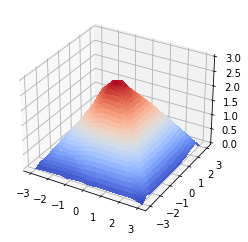

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


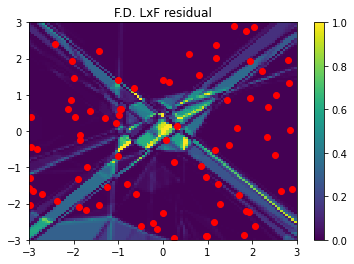

  1%|          | 8/1000 [00:00<00:12, 79.77it/s]

Mean square error: tensor(0.0066)
L-infinity error: tensor(0.4731)


100%|██████████| 1000/1000 [00:12<00:00, 81.15it/s]


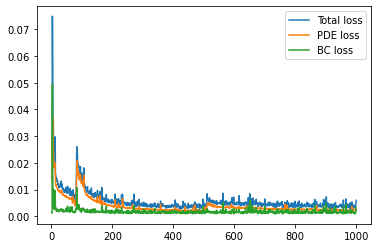

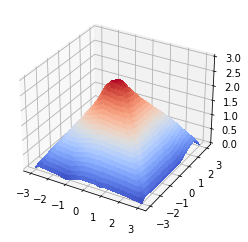

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


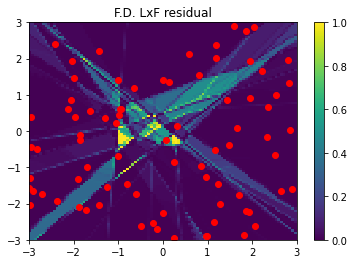

  1%|          | 7/1000 [00:00<00:15, 63.57it/s]

Mean square error: tensor(0.0073)
L-infinity error: tensor(0.4204)


100%|██████████| 1000/1000 [00:12<00:00, 77.95it/s]


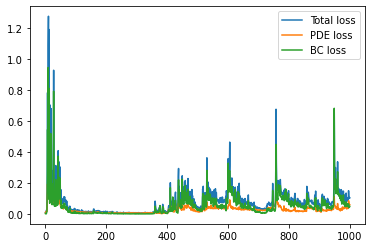

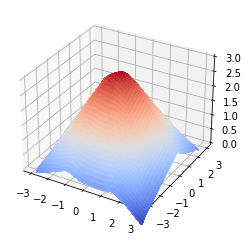

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


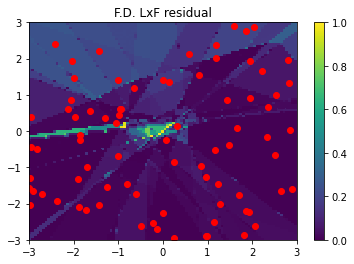

Mean square error: tensor(0.0384)
L-infinity error: tensor(0.8226)


In [2]:
# We initialise the NN
NN1 = FCFF_3L([dim,20,20])
training_params['optimizer'] = optim.SGD(NN1.parameters(), lr = .01, momentum = .2)

## Here we sample the collocation points and the boundary points.
training_data_int = domain.rand_int_points(0., 80)
training_data_bound = domain.rand_bound_points(40)

training_params['epochs'] = 1000
training_params['batch_size'] = 20

MSE_history1 = torch.zeros(rounds)
L_inf_error_history1 = torch.zeros(rounds) 

training_error_history1 = torch.zeros(rounds)
test_error_history1 = torch.zeros(rounds)

training_error_history1_max = torch.zeros(rounds)
test_error_history1_max = torch.zeros(rounds)

for i in range(rounds):
    
    training_params['alpha'] = alpha_list[i]
    training_params['delta'] = delta_list[i]

    total_loss, PDE_loss, boundary_loss = train_finite_sum(NN1, training_data_int, 
                                                           training_data_bound, training_params)

    MC_points = int(1e5) # Number of grid points for comparison with the ground truth
    MSE, L_inf = error_cube(NN1, side_length, MC_points)
    
    with torch.no_grad():
        training_error = FD_loss(NN1, training_data_int, training_params)
        test_error = FD_loss(NN1, test_data_int, training_params)
    
    training_error_history1[i] = training_error.mean()
    test_error_history1[i] = test_error.mean()
    training_error_history1_max[i] = training_error.max().item()
    test_error_history1_max[i] = test_error.max().item()
    
    MSE_history1[i] = MSE
    L_inf_error_history1[i] = L_inf
    
    epochs =  training_params['epochs']
    plt.plot(torch.arange(epochs)+1, total_loss)
    plt.plot(torch.arange(epochs)+1, PDE_loss)
    plt.plot(torch.arange(epochs)+1, boundary_loss)
    plt.legend(labels=['Total loss', 'PDE loss', 'BC loss'])
    plt.show()
    
    X_axis = 0
    Y_axis = 1
    n_grid = 100
    
    plot_2d_proj(X_axis, Y_axis, NN1, n_grid, side_length)
    plot_2d_proj_w(X_axis, Y_axis, NN1, n_grid, side_length, training_params,training_data_int)
    
    print('Mean square error:', MSE)
    print('L-infinity error:', L_inf)

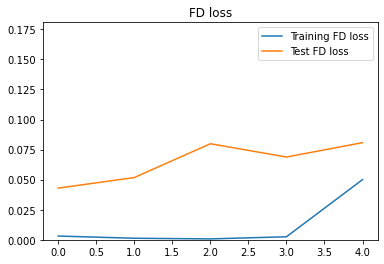

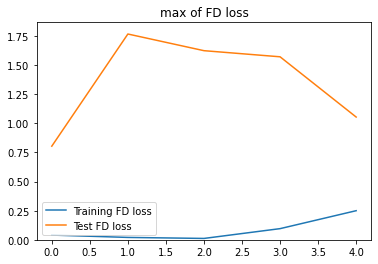

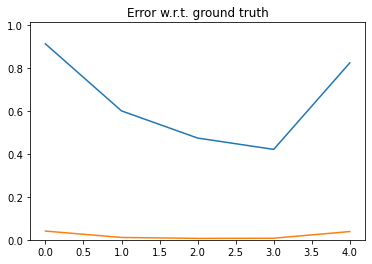

In [3]:
plt.plot(np.arange(rounds) , training_error_history1)
plt.plot(np.arange(rounds) , test_error_history1)
plt.ylim(0, test_error_history1.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , training_error_history1_max)
plt.plot(np.arange(rounds) , test_error_history1_max)
plt.ylim(0, test_error_history1_max.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history1)
plt.plot(np.arange(rounds), MSE_history1)
plt.ylim(0, L_inf_error_history1.max().item()+0.1)
plt.title('Error w.r.t. ground truth')
plt.show()

100%|██████████| 1000/1000 [00:13<00:00, 76.61it/s]


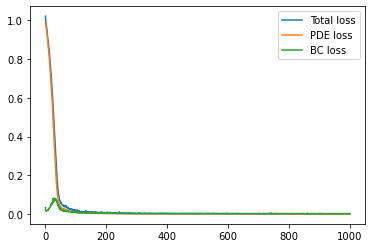

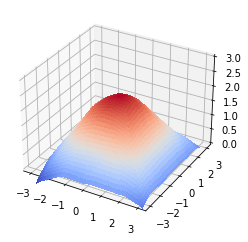

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


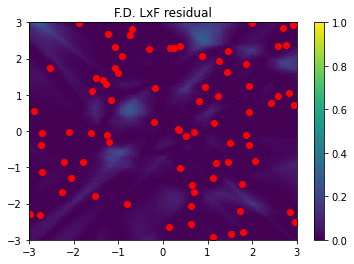

  1%|          | 8/1000 [00:00<00:12, 79.57it/s]

Mean square error: tensor(0.0511)
L-infinity error: tensor(0.9203)


100%|██████████| 1000/1000 [00:12<00:00, 82.04it/s]


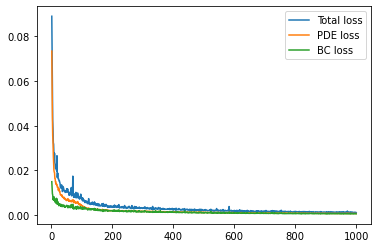

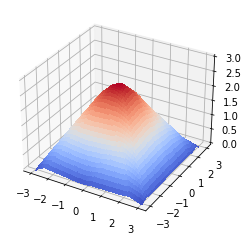

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


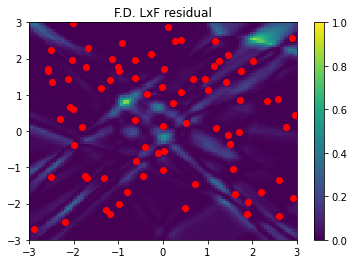

  0%|          | 5/1000 [00:00<00:20, 49.49it/s]

Mean square error: tensor(0.0097)
L-infinity error: tensor(0.5446)


100%|██████████| 1000/1000 [00:13<00:00, 75.06it/s]


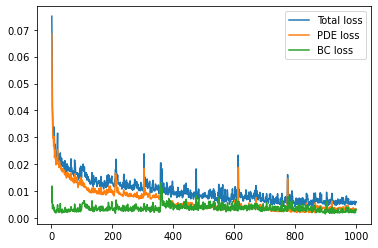

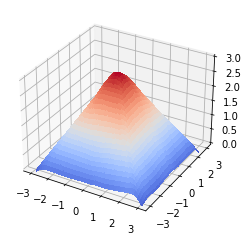

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


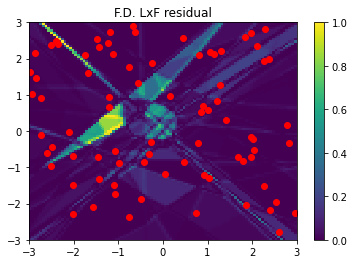

  1%|          | 8/1000 [00:00<00:13, 76.12it/s]

Mean square error: tensor(0.0071)
L-infinity error: tensor(0.3110)


100%|██████████| 1000/1000 [00:12<00:00, 78.30it/s]


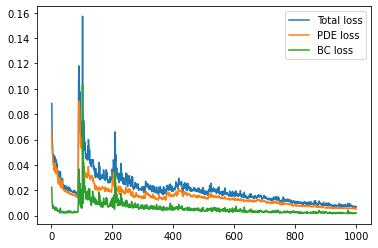

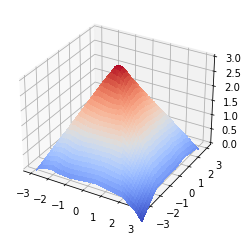

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


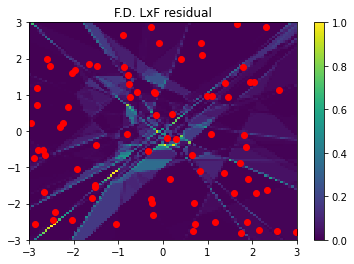

  1%|          | 8/1000 [00:00<00:13, 71.81it/s]

Mean square error: tensor(0.0141)
L-infinity error: tensor(0.6906)


100%|██████████| 1000/1000 [00:12<00:00, 83.32it/s]


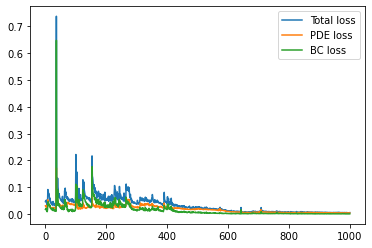

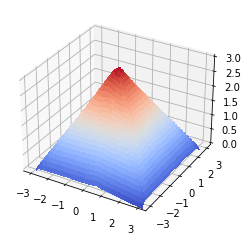

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


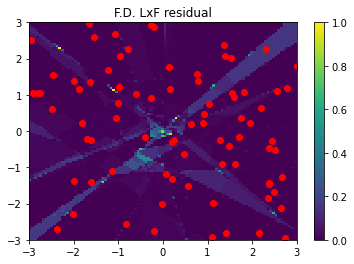

Mean square error: tensor(0.0036)
L-infinity error: tensor(0.2274)


In [4]:
# We initialise the NN
NN2 = FCFF_3L([dim,20,20])
training_params['optimizer'] = optim.SGD(NN2.parameters(), lr = .01, momentum = .2)

training_params['epochs'] = 1000
training_params['batch_size'] = 20

MSE_history2 = torch.zeros(rounds)
L_inf_error_history2 = torch.zeros(rounds) 

training_error_history2 = torch.zeros(rounds)
test_error_history2 = torch.zeros(rounds)

training_error_history2_max = torch.zeros(rounds)
test_error_history2_max = torch.zeros(rounds)

for i in range(rounds):
    
    ## Here we sample the collocation points and the boundary points.
    training_data_int = domain.rand_int_points(0., 80)
    training_data_bound = domain.rand_bound_points(40)
    
    training_params['alpha'] = alpha_list[i]
    training_params['delta'] = delta_list[i]

    total_loss, PDE_loss, boundary_loss = train_finite_sum(NN2, training_data_int, 
                                                           training_data_bound, training_params)

    MC_points = int(1e5) # Number of grid points for comparison with the ground truth
    MSE, L_inf = error_cube(NN2, side_length, MC_points)
    
    with torch.no_grad():
        training_error = FD_loss(NN2, training_data_int, training_params)
        test_error = FD_loss(NN2, test_data_int, training_params)
    
    training_error_history2[i] = training_error.mean()
    test_error_history2[i] = test_error.mean()
    training_error_history2_max[i] = training_error.max().item()
    test_error_history2_max[i] = test_error.max().item()
    
    MSE_history2[i] = MSE
    L_inf_error_history2[i] = L_inf
    
    epochs =  training_params['epochs']
    plt.plot(torch.arange(epochs)+1, total_loss)
    plt.plot(torch.arange(epochs)+1, PDE_loss)
    plt.plot(torch.arange(epochs)+1, boundary_loss)
    plt.legend(labels=['Total loss', 'PDE loss', 'BC loss'])
    plt.show()
    
    X_axis = 0
    Y_axis = 1
    n_grid = 100
    
    plot_2d_proj(X_axis, Y_axis, NN2, n_grid, side_length)
    plot_2d_proj_w(X_axis, Y_axis, NN2, n_grid, side_length, training_params,training_data_int)
    
    print('Mean square error:', MSE)
    print('L-infinity error:', L_inf)

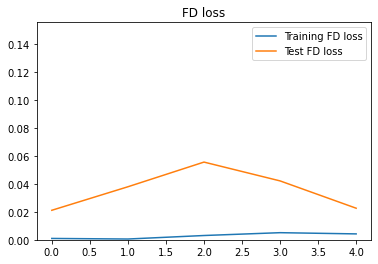

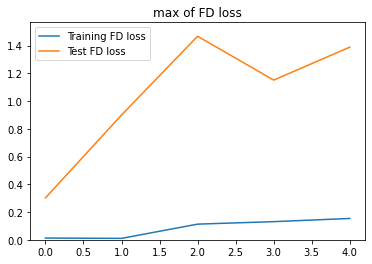

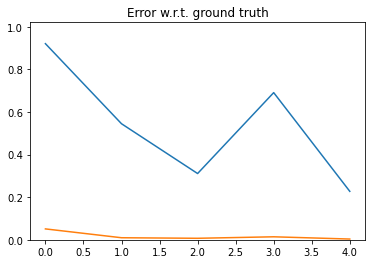

In [5]:
plt.plot(np.arange(rounds) , training_error_history2)
plt.plot(np.arange(rounds) , test_error_history2)
plt.ylim(0, test_error_history2.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , training_error_history2_max)
plt.plot(np.arange(rounds) , test_error_history2_max)
plt.ylim(0, test_error_history2_max.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history2)
plt.plot(np.arange(rounds), MSE_history2)
plt.ylim(0, L_inf_error_history2.max().item()+0.1)
plt.title('Error w.r.t. ground truth')
plt.show()

100%|██████████| 1000/1000 [00:05<00:00, 174.94it/s]


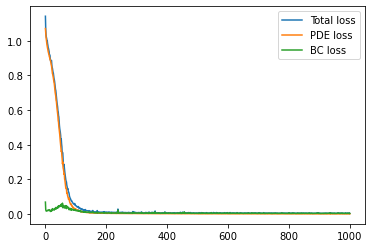

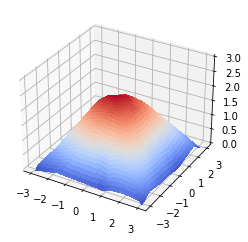

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


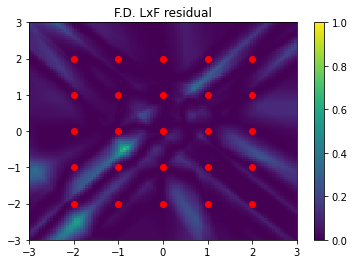

  1%|▏         | 14/1000 [00:00<00:07, 139.64it/s]

Mean square error: tensor(0.0472)
L-infinity error: tensor(0.9402)


100%|██████████| 1000/1000 [00:05<00:00, 174.55it/s]


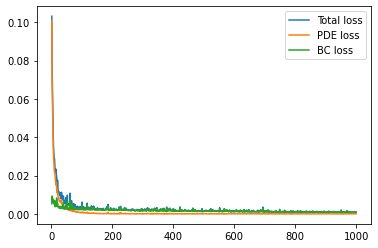

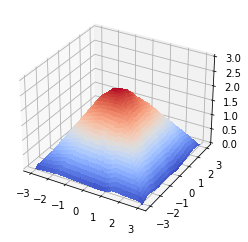

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


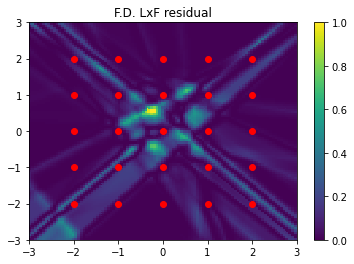

  1%|▏         | 13/1000 [00:00<00:07, 128.17it/s]

Mean square error: tensor(0.0224)
L-infinity error: tensor(0.6915)


100%|██████████| 1000/1000 [00:06<00:00, 147.61it/s]


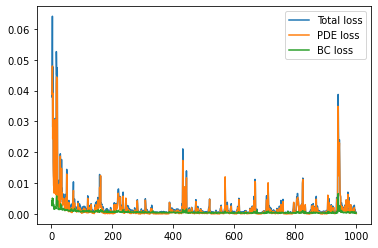

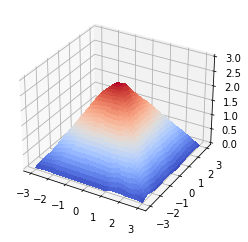

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


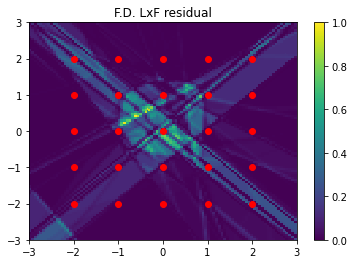

  2%|▏         | 15/1000 [00:00<00:06, 145.48it/s]

Mean square error: tensor(0.0092)
L-infinity error: tensor(0.5038)


100%|██████████| 1000/1000 [00:06<00:00, 149.04it/s]


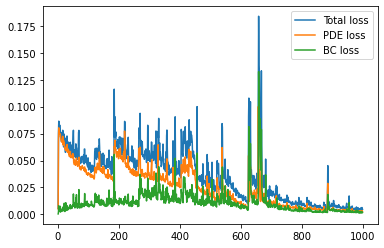

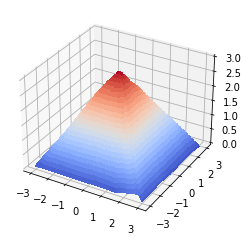

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


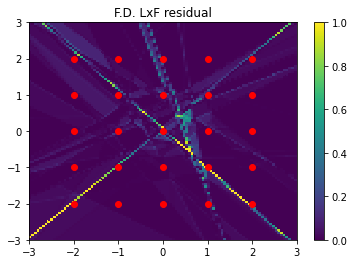

  2%|▏         | 15/1000 [00:00<00:06, 148.64it/s]

Mean square error: tensor(0.0026)
L-infinity error: tensor(0.2101)


100%|██████████| 1000/1000 [00:06<00:00, 161.81it/s]


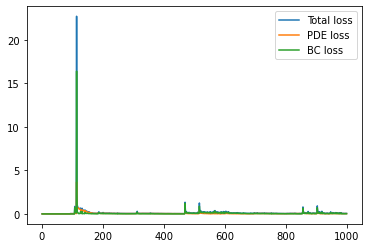

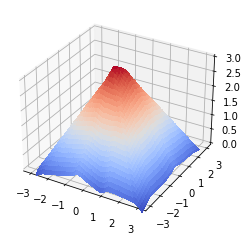

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


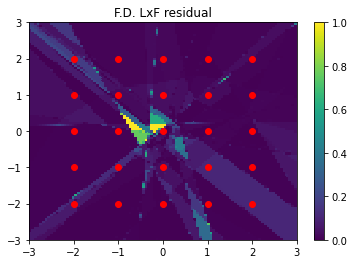

Mean square error: tensor(0.0163)
L-infinity error: tensor(0.4065)


In [15]:
# We initialise the NN
NN3 = FCFF_3L([dim,20,20])
training_params['optimizer'] = optim.SGD(NN3.parameters(), lr = .01, momentum = .2)

training_params['epochs'] = 1000
training_params['batch_size'] = 20

MSE_history3 = torch.zeros(rounds)
L_inf_error_history3 = torch.zeros(rounds) 

training_error_history3 = torch.zeros(rounds)
test_error_history3 = torch.zeros(rounds)

training_error_history3_max = torch.zeros(rounds)
test_error_history3_max = torch.zeros(rounds)


## Here we sample the collocation points and the boundary points.
training_data_int, training_data_bound = get_unif_grid(side_length, dim, 7)

for i in range(rounds):
    
    training_params['alpha'] = alpha_list[i]
    training_params['delta'] = delta_list[i]

    total_loss, PDE_loss, boundary_loss = train_finite_sum(NN3, training_data_int, 
                                                           training_data_bound, training_params)

    MC_points = int(1e5) # Number of grid points for comparison with the ground truth
    MSE, L_inf = error_cube(NN3, side_length, MC_points)
    
    with torch.no_grad():
        training_error = FD_loss(NN3, training_data_int, training_params)
        test_error = FD_loss(NN3, test_data_int, training_params)
    
    training_error_history3[i] = training_error.mean()
    test_error_history3[i] = test_error.mean()
    training_error_history3_max[i] = training_error.max().item()
    test_error_history3_max[i] = test_error.max().item()
    
    MSE_history3[i] = MSE
    L_inf_error_history3[i] = L_inf
    
    epochs =  training_params['epochs']
    plt.plot(torch.arange(epochs)+1, total_loss)
    plt.plot(torch.arange(epochs)+1, PDE_loss)
    plt.plot(torch.arange(epochs)+1, boundary_loss)
    plt.legend(labels=['Total loss', 'PDE loss', 'BC loss'])
    plt.show()
    
    X_axis = 0
    Y_axis = 1
    n_grid = 100
    
    plot_2d_proj(X_axis, Y_axis, NN3, n_grid, side_length)
    plot_2d_proj_w(X_axis, Y_axis, NN3, n_grid, side_length, training_params,training_data_int)
    
    print('Mean square error:', MSE)
    print('L-infinity error:', L_inf)

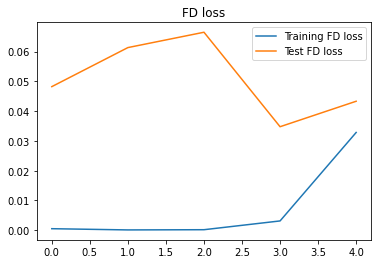

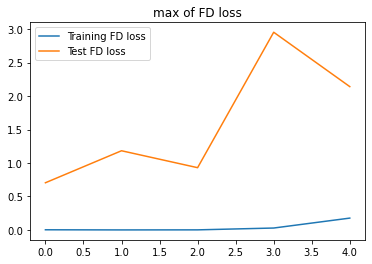

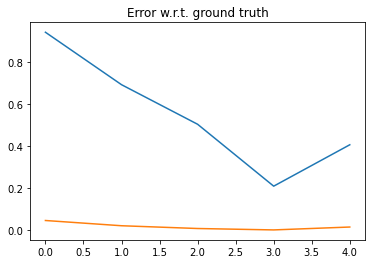

In [16]:
plt.plot(np.arange(rounds) , training_error_history3)
plt.plot(np.arange(rounds) , test_error_history3)
#plt.ylim(0, test_error_history3.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.title('FD loss')
plt.show()

plt.plot(np.arange(rounds) , training_error_history3_max)
plt.plot(np.arange(rounds) , test_error_history3_max)
#plt.ylim(0, test_error_history3_max.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history3)
plt.plot(np.arange(rounds), MSE_history3)
#plt.ylim(0, L_inf_error_history3.max().item()+0.1)
plt.title('Error w.r.t. ground truth')
plt.show()

100%|██████████| 2500/2500 [00:03<00:00, 725.97it/s]


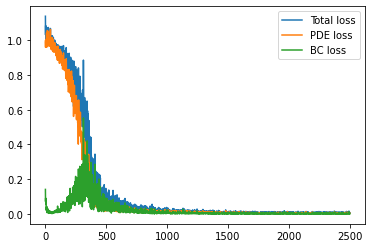

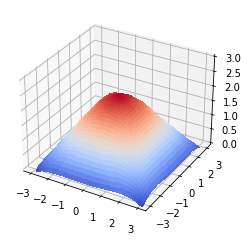

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


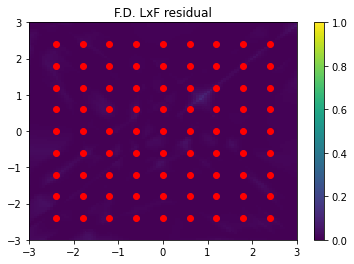

  2%|▏         | 61/2500 [00:00<00:04, 608.56it/s]

Mean square error: tensor(0.0386)
L-infinity error: tensor(0.8977)


100%|██████████| 2500/2500 [00:03<00:00, 628.75it/s]


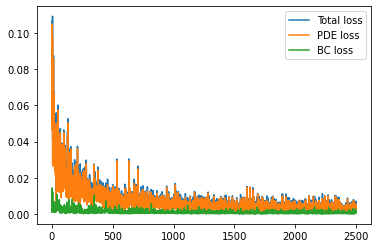

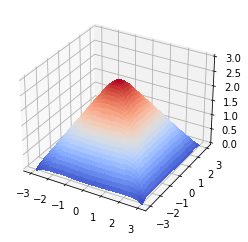

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


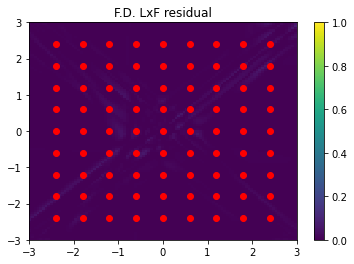

  2%|▏         | 55/2500 [00:00<00:04, 549.15it/s]

Mean square error: tensor(0.0033)
L-infinity error: tensor(0.4001)


100%|██████████| 2500/2500 [00:04<00:00, 568.21it/s]


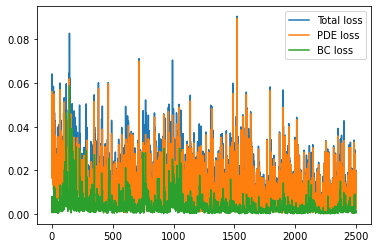

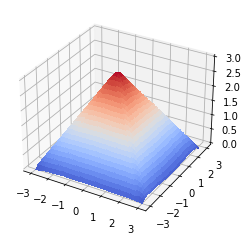

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


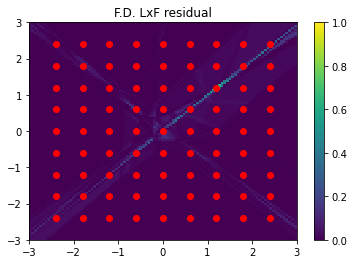

  3%|▎         | 71/2500 [00:00<00:03, 706.83it/s]

Mean square error: tensor(0.0014)
L-infinity error: tensor(0.1729)


100%|██████████| 2500/2500 [00:03<00:00, 660.41it/s]


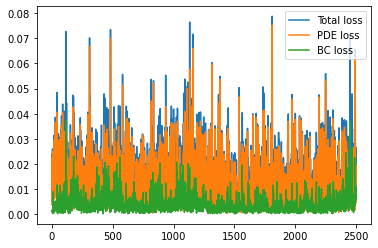

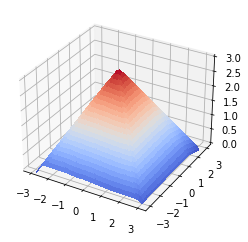

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


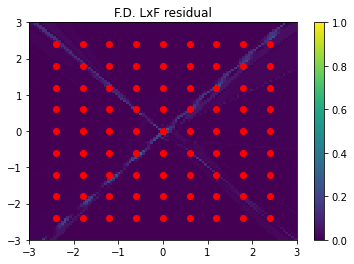

  2%|▏         | 60/2500 [00:00<00:04, 598.26it/s]

Mean square error: tensor(0.0035)
L-infinity error: tensor(0.2193)


100%|██████████| 2500/2500 [00:03<00:00, 674.12it/s]


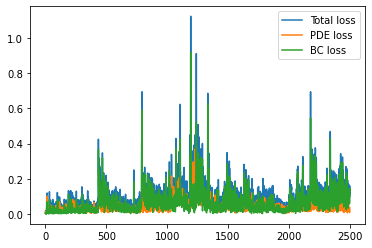

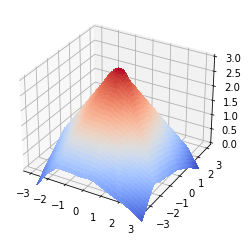

../visualization/cube_training.py:43: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), W.detach())


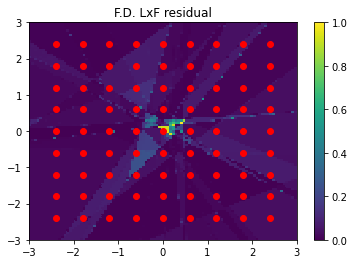

Mean square error: tensor(0.0538)
L-infinity error: tensor(0.8849)


In [10]:
from Training.training import train

# We initialise the NN
NN4 = FCFF_3L([dim,20,20])
training_params['optimizer'] = optim.SGD(NN4.parameters(), lr = .01, momentum = .2)

training_params['n_coloc_points'] = 20
training_params['n_boundary_points'] = 8
training_params['num_iterations'] = 2500

MSE_history4 = torch.zeros(rounds)
L_inf_error_history4 = torch.zeros(rounds) 

#training_error_history4 = torch.zeros(rounds)
test_error_history4 = torch.zeros(rounds)

training_error_history4_max = torch.zeros(rounds)
test_error_history4_max = torch.zeros(rounds)

for i in range(rounds):
    
    training_params['alpha'] = alpha_list[i]
    training_params['delta'] = delta_list[i]

    total_loss, PDE_loss, boundary_loss = train(NN4, domain, training_params)

    MC_points = int(1e5) # Number of grid points for comparison with the ground truth
    MSE, L_inf = error_cube(NN4, side_length, MC_points)
    
    with torch.no_grad():
        #training_error = FD_loss(NN4, training_data_int, training_params)
        test_error = FD_loss(NN4, test_data_int, training_params)
    
    #training_error_history4[i] = training_error.mean()
    test_error_history4[i] = test_error.mean()
    #training_error_history4_max[i] = training_error.max().item()
    test_error_history4_max[i] = test_error.max().item()
    
    MSE_history4[i] = MSE
    L_inf_error_history4[i] = L_inf
    
    epochs =  training_params['epochs']
    plt.plot(total_loss)
    plt.plot(PDE_loss)
    plt.plot(boundary_loss)
    plt.legend(labels=['Total loss', 'PDE loss', 'BC loss'])
    plt.show()
    
    X_axis = 0
    Y_axis = 1
    n_grid = 100
    
    plot_2d_proj(X_axis, Y_axis, NN4, n_grid, side_length)
    plot_2d_proj_w(X_axis, Y_axis, NN4, n_grid, side_length, training_params)
    
    print('Mean square error:', MSE)
    print('L-infinity error:', L_inf)

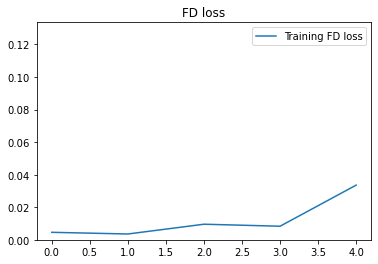

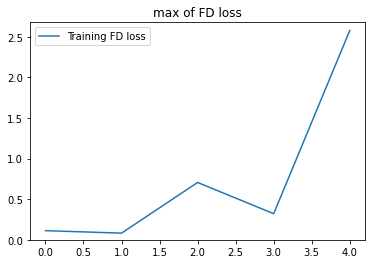

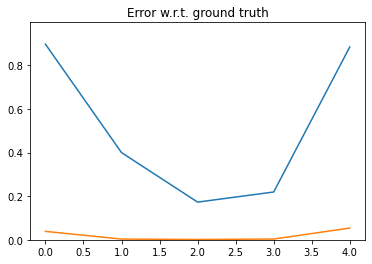

In [11]:
#plt.plot(np.arange(rounds) , training_error_history4)
plt.plot(np.arange(rounds) , test_error_history4)
plt.ylim(0, test_error_history4.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.title('FD loss')
plt.show()

#plt.plot(np.arange(rounds) , training_error_history4_max)
plt.plot(np.arange(rounds) , test_error_history4_max)
plt.ylim(0, test_error_history4_max.max().item()+.1)
plt.legend(labels = ['Training FD loss', 'Test FD loss'])
plt.title('max of FD loss')
plt.show()

plt.plot(np.arange(rounds), L_inf_error_history4)
plt.plot(np.arange(rounds), MSE_history4)
plt.ylim(0, L_inf_error_history4.max().item()+0.1)
plt.title('Error w.r.t. ground truth')
plt.show()

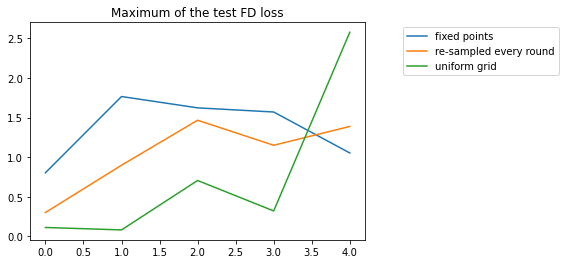

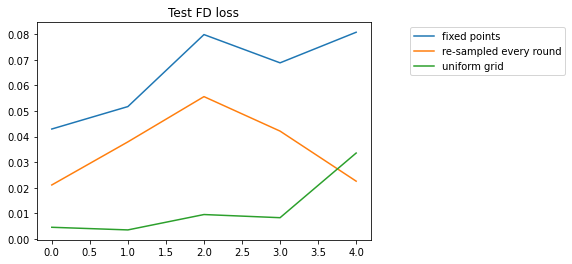

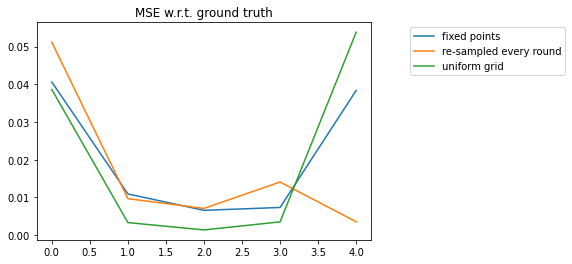

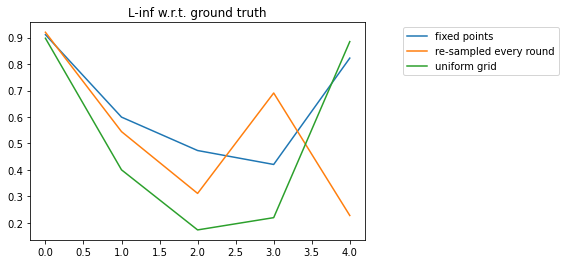

In [14]:
plt.plot(np.arange(rounds) , test_error_history1_max)
plt.plot(np.arange(rounds) , test_error_history2_max)
#plt.plot(np.arange(rounds) , test_error_history3_max)
plt.plot(np.arange(rounds) , test_error_history4_max)
plt.title('Maximum of the test FD loss')
plt.legend(labels = ['fixed points', 're-sampled every round', 'uniform grid', 're-sampled every iteration'], 
           bbox_to_anchor=(1.1, 1.0))

plt.show()

plt.plot(np.arange(rounds) , test_error_history1)
plt.plot(np.arange(rounds) , test_error_history2)
#plt.plot(np.arange(rounds) , test_error_history3)
plt.plot(np.arange(rounds) , test_error_history4)
plt.title('Test FD loss')
plt.legend(labels = ['fixed points', 're-sampled every round', 'uniform grid', 're-sampled every iteration'], 
           bbox_to_anchor=(1.1, 1.0))

plt.show()

plt.plot(np.arange(rounds) , MSE_history1)
plt.plot(np.arange(rounds) , MSE_history2)
#plt.plot(np.arange(rounds) , MSE_history3)
plt.plot(np.arange(rounds) , MSE_history4)
plt.title('MSE w.r.t. ground truth')
plt.legend(labels = ['fixed points', 're-sampled every round', 'uniform grid', 're-sampled every iteration'], 
           bbox_to_anchor=(1.1, 1.0))
plt.show()
          
plt.plot(np.arange(rounds) , L_inf_error_history1)
plt.plot(np.arange(rounds) , L_inf_error_history2)
#plt.plot(np.arange(rounds) , L_inf_error_history3)
plt.plot(np.arange(rounds) , L_inf_error_history4)
plt.title('L-inf w.r.t. ground truth')
plt.legend(labels = ['fixed points', 're-sampled every round', 'uniform grid', 're-sampled every iteration'], 
           bbox_to_anchor=(1.1, 1.0))
plt.show()